In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared
from sklearn.datasets import make_friedman2
from src.preprocessing.preprocessing import prepare_atlas_cen_data
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.graph_objects as go

In [31]:
data = prepare_atlas_cen_data('../data/_atlas_cen_scraped.csv')
X, y = data[['long', 'lat']].to_numpy(), data['price/m2'].to_numpy()
xmin=14.1
xmax=14.75
ymax=50.25
ymin=49.91
bbox = (14.2700, 14.6000, 50.0000, 50.1400)

In [32]:
X[:, 0].min()

13.817231400856546

In [4]:
print(y.min(), y.max(), np.median(y), np.mean(y), np.quantile(y, 0.9999))

20256.0 7627119.0 110172.5 113719.41238767651 3734183.984101282


In [272]:
y


array([210262.,  79203., 113876., ...,  77350., 140351., 120433.])

In [276]:
y[np.where(y>250000)[0]]

array([ 351240.,  251574.,  305147.,  327273.,  334448.,  265181.,
        253848.,  250591.,  308802.,  280900.,  276316.,  279395.,
        684240.,  350000.,  269231.,  259067., 7627119.,  289729.,
       1379430.,  264216.,  250706.,  285128.,  255923.,  288000.,
        359195.,  270479.,  383333.,  266667.,  414847.,  767494.,
        770878.,  431085.,  255438.,  291027.,  279630.,  999557.,
        255036.,  252538.,  273723.,  364609.,  275721.,  970768.,
        287519.,  293850.])

## There is few extremal prices

so we will partition dataset according to kind of normal prices and high prices (above 250000 per m2)

In [290]:
valid_ids_low = np.where(((X[:, 0] > bbox[0]) & (X[:, 0] < bbox[1]) & (X[:, 1] < bbox[3]) & (X[:, 1] > bbox[2])
                             & (y < 250000)))[0]
valid_ids_high = np.where(((X[:, 0] > bbox[0]) & (X[:, 0] < bbox[1]) & (X[:, 1] < bbox[3]) & (X[:, 1] > bbox[2])
                             & (y >= 250000)))[0]

X_low, y_low = X[valid_ids_low], y[valid_ids_low]
X_high, y_high = X[valid_ids_high], y[valid_ids_high]
X_all, y_all = np.concatenate([X_low, X_high]), np.concatenate([y_low, y_high])

In [296]:
print(y_low.min(), y_low.max(), np.median(y_low), np.mean(y_low), np.quantile(y_low, 0.99))
print(y_all.min(), y_all.max(), np.median(y_all), np.mean(y_all), np.quantile(y_all, 0.99))

47376.0 247261.0 119804.0 123639.85875440658 215767.32
47376.0 7627119.0 120239.0 128020.58069767442 250592.15000000002


Using all datapoints doesnt change much 99% quantile, mean and median

## Plot of all datapoints at disposal

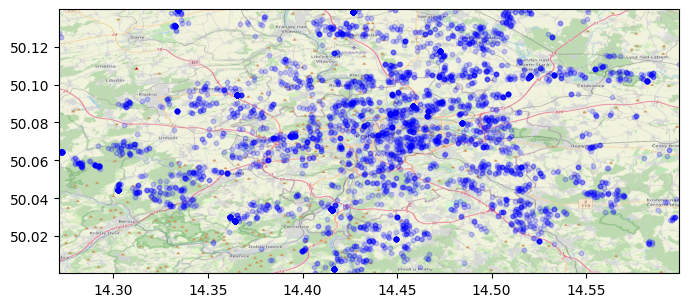

In [51]:
image_path = '../data/misc/map.png'
img= plt.imread(image_path)

fig, ax = plt.subplots(figsize = (8,7))

ax.scatter(X[:, 0], X[:, 1], zorder=1, alpha= 0.2, c='b', s=10)
ax.set_xlim(X[:, 0].min(),X[:, 0].max())
ax.set_ylim(X[:, 1].min(),X[:, 1].max())
ax.imshow(img, zorder=0, extent = (X[:, 0].min(),X[:, 0].max(),X[:, 1].min(),X[:, 1].max()), aspect= 'equal')

plt.show()

## Dataset partition according to prices

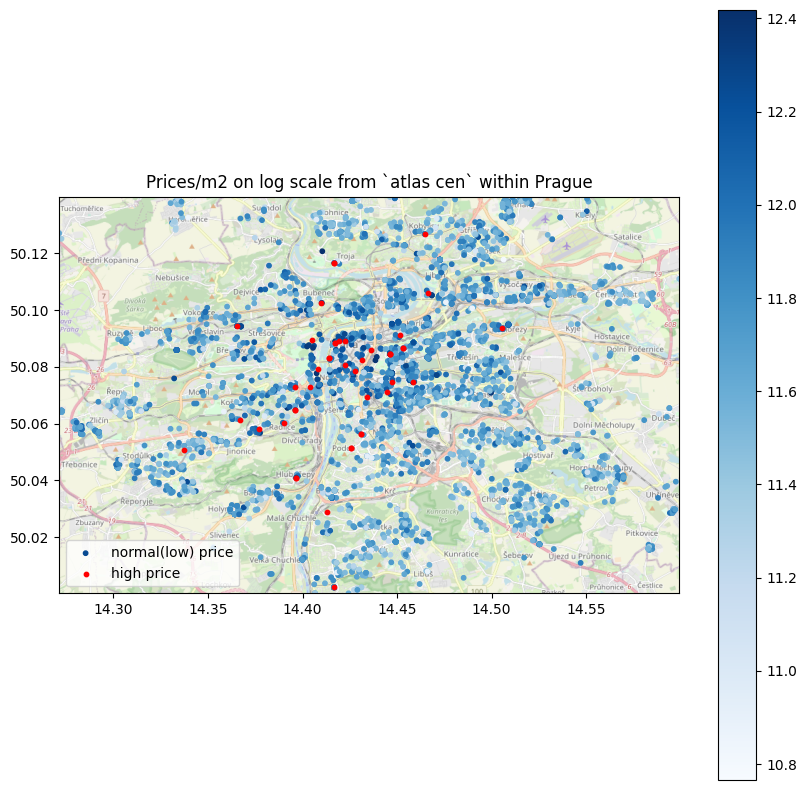

In [311]:
image_path_2 = '../data/misc/map2.png'
img= plt.imread(image_path_2)

bbox = (14.2700, 14.6000, 50.0000, 50.1400)

fig, ax = plt.subplots(figsize = (10,10))

sc = ax.scatter(X_low[:, 0], X_low[:, 1], zorder=1, alpha= 1, c=np.log(y_low), s=10, cmap=cm.Blues,vmin=np.log(y_low).min(),
                                                                                       vmax=np.log(y_low).max(),
               label='normal(low) price')
ax.scatter(X_high[:, 0], X_high[:, 1], zorder=1, alpha= 1, c='red', s=10, label='high price')
ax.set_xlim(X_all[:, 0].min(),X_all[:, 0].max())
ax.set_ylim(X_all[:, 1].min(),X_all[:, 1].max())
ax.imshow(img, extent = bbox, aspect=1250/833, alpha=0.7)  # aspect is not 1 because y-spacing is different from x-spacing
ax.set_title('Prices/m2 on log scale from `atlas cen` within Prague')
fig.colorbar(sc)
ax.legend()
plt.show()

# Prepare set of query datapoints
#### To perform a more detailed discretization, we will need to use for loops and query predictions on subareas of whole discretized net of points because this process is very memory consuming

In [313]:
x, y_ = np.mgrid[bbox[0]:bbox[1]:1e-2, bbox[2]:bbox[3]:1e-2]  # delta corresponds to ~1250m in y axis and ~833m in x axis
net = np.vstack([x.flatten(), y_.flatten()]).T
net.shape

(510, 2)

## Fit gaussian process on all price datapoints

Note that hyperparams of proposed GP was tuned just by hand to get rough estimates
* Main problem was that some configurations resulted in negative predictions of prices


In [264]:
gpr = GaussianProcessRegressor(kernel=Matern(length_scale=0.0008, length_scale_bounds='fixed', nu=0.5),
                                   random_state=0, normalize_y=True).fit(X_all, y_all)

In [219]:
gpr_rat = GaussianProcessRegressor(kernel=RationalQuadratic(length_scale=0.8, length_scale_bounds='fixed', alpha=0.1),
                                   random_state=0, normalize_y=True).fit(X_all, y_all)

/media/emanuel/data/miniconda3/envs/re/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning:

The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



In [265]:
gpr.score(X, y)

0.9847847868605052

In [266]:
z = gpr.predict(net)
z.mean(), z.min(), z.max(), z.shape

(128372.69044707085, 85719.32046441037, 274713.3229766219, (510,))

In [314]:
"""
image_path_2 = '../data/misc/map2.png'
img= plt.imread(image_path_2)


fig, ax = plt.subplots(figsize = (20,20))

ax.contour(x=x, y=y_, z=z.reshape(x.shape))
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.imshow(img, zorder=0, extent = bbox, aspect=1250/833, alpha=0.4)  # aspect is not 1 because y-spacing is different from x-spacing
ax.set_title('Plotting scraped datapoints from `atlas cen` within Prague')

plt.show()
"""

"\nimage_path_2 = '../data/misc/map2.png'\nimg= plt.imread(image_path_2)\n\n\nfig, ax = plt.subplots(figsize = (20,20))\n\nax.contour(x=x, y=y_, z=z.reshape(x.shape))\nax.set_xlim(bbox[0],bbox[1])\nax.set_ylim(bbox[2],bbox[3])\nax.imshow(img, zorder=0, extent = bbox, aspect=1250/833, alpha=0.4)  # aspect is not 1 because y-spacing is different from x-spacing\nax.set_title('Plotting scraped datapoints from `atlas cen` within Prague')\n\nplt.show()\n"

## Prediction (mean func) of GP as contours

In [315]:
fig = go.Figure(data=[go.Contour(z=z.reshape(x.shape).T, x=np.rot90(x)[0, :], y=np.rot90(y_)[:, 0],
                contours=dict(
                start=20000,
                end=250000,
                size=10000),
                                opacity=1)])
fig.add_layout_image(  # --> not working not sure why
        dict(
            source=image_path_2,
            opacity=0.98,
            sizing="stretch",
            layer="below")
    
)
fig.update_layout(template="plotly_white")
fig.show()

## Prediction (mean func) of GP as surface

In [267]:
fig = go.Figure(data=[go.Surface(z=z.reshape(x.shape).T, x=np.rot90(x)[0, :], y=np.rot90(y_)[:, 0])])
fig.show()

## Fit gaussian process on (low) price datapoints

In [316]:
gpr = GaussianProcessRegressor(kernel=Matern(length_scale=0.0008, length_scale_bounds='fixed', nu=0.5),
                                   random_state=0, normalize_y=True).fit(X_low, y_low)

In [317]:
z = gpr.predict(net)
z.mean(), z.min(), z.max(), z.shape

(123753.12463552806, 84129.65812938305, 173125.84456761726, (510,))

## Prediction (mean func) of GP as contours

In [319]:
fig = go.Figure(data=[go.Contour(z=z.reshape(x.shape).T, x=np.rot90(x)[0, :], y=np.rot90(y_)[:, 0],
                contours=dict(
                start=20000,
                end=250000,
                size=10000),
                                opacity=1)])
fig.show()

## Prediction (mean func) of GP as surface
maybe there is way how to add image of map into graph but dont know how

In [320]:
fig = go.Figure(data=[go.Surface(z=z.reshape(x.shape).T, x=np.rot90(x)[0, :], y=np.rot90(y_)[:, 0])])
fig.show()